In [13]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.tikhonov as tikhonov
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

State: 1 | Realization: 0
State: 1 | Realization: 1
State: 1 | Realization: 2
State: 1 | Realization: 3
State: 1 | Realization: 4
State: 1 | Realization: 5
State: 1 | Realization: 6
State: 1 | Realization: 7
State: 1 | Realization: 8
State: 1 | Realization: 9
State: 1 | Realization: 10
State: 1 | Realization: 11
State: 1 | Realization: 12
State: 1 | Realization: 13
State: 1 | Realization: 14
State: 1 | Realization: 15
State: 1 | Realization: 16
State: 1 | Realization: 17
State: 1 | Realization: 18
State: 1 | Realization: 19
State: 1 | Realization: 20
State: 1 | Realization: 21
State: 1 | Realization: 22
State: 1 | Realization: 23
State: 1 | Realization: 24
State: 1 | Realization: 25
State: 1 | Realization: 26
State: 1 | Realization: 27
State: 1 | Realization: 28
State: 1 | Realization: 29
State: 1 | Realization: 30
State: 1 | Realization: 31
State: 1 | Realization: 32
State: 1 | Realization: 33
State: 1 | Realization: 34
State: 1 | Realization: 35
State: 1 | Realization: 36
State: 1 | 

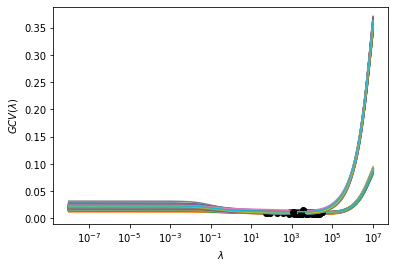

In [16]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/Duffing_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)

# noise_lvls = [0.001, 0.01, 0.1, 1, 2]
noise_lvls = [0.1]

n_noise_lvls = len(noise_lvls)

mean_X_error = np.zeros((n_states, n_noise_lvls))
mean_dX_error = np.zeros((n_states, n_noise_lvls))

var_X_error = np.zeros((n_states, n_noise_lvls))
var_dX_error = np.zeros((n_states, n_noise_lvls))  

for noise, sigma in enumerate(noise_lvls):

    # 2) LOAD OBSERVATION SAMPLES
    Y_samples = []
    noise_lvl = str(sigma)

    for state in range(n_states):

        filepath = 'data_files/Duffing_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
        y = np.genfromtxt(filepath, delimiter=',')

        Y_samples.append(y)

    n_samples = Y_samples[0].shape[0]

    ################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
    trim = int(np.floor(5 / 100 * t_samples))
    error_X = np.zeros((n_samples,n_states))
    error_dX = np.zeros((n_samples,n_states))
    tt_samples = t_samples - 2 * trim
    Yhat_tik = np.zeros((n_samples, tt_samples))
    DYhat_tik = np.zeros((n_samples, tt_samples))

    for state in range(n_states):

        for sample in range(n_samples):#n_samples
            
            y = Y_samples[state][sample,:]
            
            #Find optimal lambda through GCV
            tik = tikhonov.gcv(y, lambda_min = 1e-8, lambda_max = 10000000, n_lambdas = 1000, plot_lc = True)
            y_tik = tik[0]
#             lambdas, gcv = tik[1]

            y_tik_ss = interpolate.splrep(t, y_tik, k=3, s=0)
            dy_tik = interpolate.splev(t, y_tik_ss, der=1)
            
            #Remove ends
            Yhat_tik[sample,:] = y_tik[trim:-trim]
            DYhat_tik[sample,:] = dy_tik[trim:-trim]
            
            #Compute errors
            error_X[sample,state] = norm(Yhat_tik[sample,:] - X[state,trim:-trim]) / norm(X[state,trim:-trim])
            error_dX[sample,state] = norm(DYhat_tik[sample,:] - DX[state,trim:-trim]) / norm(DX[state,trim:-trim])
            print('State: ' + str(state+1) + ' | ' + 'Realization: ' + str(sample))
        filename_y = 'data_files/tikhonov_hp/Duffing_tikhonov_hp_gcv_' + noise_lvl + '_Y' + str(state+1) + '.csv'
        filename_dy = 'data_files/tikhonov_hp/Duffing_tikhonov_hp_gcv_' + noise_lvl + '_dY' + str(state+1) + '.csv'
        with open(filename_y, 'w') as csvfile:   
            # creating a csv writer object   
            csvwriter = csv.writer(csvfile)   
            # writing the data rows   
            csvwriter.writerows(Yhat_tik)
        with open(filename_dy, 'w') as csvfile:   
            # creating a csv writer object   
            csvwriter = csv.writer(csvfile)   
            # writing the data rows   
            csvwriter.writerows(DYhat_tik)

        mean_X_error[state, noise] = error_X[:,state].mean()
        mean_dX_error[state, noise] = error_dX[:,state].mean()
        var_X_error[state, noise] = error_X[:,state].var()
        var_dX_error[state, noise] = error_dX[:,state].var()
        
      

In [17]:

temp = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp for item in sublist])

state_indx = np.array(['state x' + str(x+1) for x in range(n_states)] * n_noise_lvls)

arrays = [noise_indx, state_indx]
data = np.vstack((mean_X_error.T.flatten(), var_X_error.T.flatten(), mean_dX_error.T.flatten(), var_dX_error.T.flatten())).T

col_names = ['mean error x', 'var. error x', 'mean error dx', 'var. error dx']
df = pd.DataFrame(data, index=arrays, columns=col_names)
df

mean error x  var. error x  mean error dx  \
$\sigma$ = 0.1 state x1      0.026006      0.000064       0.101246   
               state x2      0.015088      0.000014       0.065295   

                         var. error dx  
$\sigma$ = 0.1 state x1       0.007197  
               state x2       0.000868

In [ ]:
#Cheat sheet

#noise = 0.001 -- > lambda_min = 1e-12, lambda_max = 10